# Understanding Airbnb Spaces in New York City

In this data analysis, we will be scraping Airbnb data and gathering insights to form valuable conclusions. We will do linear regression and map visualizations to understand what factors affect price and ratings of Airbnb listings in New York City.

Specifically, we'll be addressing the following research Questions:

1. Part I: Which neighborhoods in New York City have the costliest Airbnb listings?
2. Part II: Which factors have the greatest influence on the price of an Airbnb listing?
3. Part III: Which factors have the greatest influence on the star rating of an Airbnb listing?

## Getting the Data

Since Airbnb has no official API, one must reverse engineer the endpoints by looking at network requests from the Public Airbnb listings page. Luckily, a [third party website](http://airbnbapi.org/) discovered the endpoints for us. We will be using the Search and Listing Info endpoints. Click on the endpoints to get the raw json results.

Search Listings (by location "New York"): 
https://api.airbnb.com/v2/search_results?client_id=3092nxybyb0otqw18e8nh5nty&locale=USD&location=New+York

Listing Info (by listing ID):
https://api.airbnb.com/v2/listings/5116458?client_id=3092nxybyb0otqw18e8nh5nty&_format=v1_legacy_for_p3

The following code is a sample of the AirbnbClient script to search for a number of listings in a location, and save certain parameters to a CSV file. 


You can use the `airbnb-client.py` script to get results yourself.  

In [18]:
import requests
import sys
import csv
import time
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

In [8]:
class AirbnbClient:
    def __init__(self):

        CLIENT_ID = "3092nxybyb0otqw18e8nh5nty"
        self.REQUEST_INTERVAL = .1
        self.DEBUG = True
        self.MAX_LIMIT = 50
        self.search_url = "https://api.airbnb.com/v2/search_results?client_id=" + CLIENT_ID
        self.listing_url = "https://api.airbnb.com/v2/listings/%d?client_id="+CLIENT_ID+"&_format=v1_legacy_for_p3"

    def scrape(self, location, num_listings):
        num_loops = (num_listings / self.MAX_LIMIT) + 1

        offset = 0
        listings = []
        while num_listings > 0:
            listings += self.search(location, limit=min(num_listings, self.MAX_LIMIT), offset=offset)
            num_listings -= self.MAX_LIMIT
            offset += self.MAX_LIMIT

        listings = map(lambda l: l["listing"]["id"], listings)

        return listings

    def search(self, location, limit, offset, locale="USD"):

        params = {
            "locale": locale,
            "_limit": limit,
            "_offset": offset,
            "location": location
        }
        resp = requests.get(self.search_url, params=params)
        if resp.status_code != 200:
            print "Error occured in request to %s" % self.search_url
            return []
        results = resp.json()
        
        return results["search_results"]
    
    

This code uses pagination to get however many search results are requested. Since the API search result limit is 50, offsets are needed for returning more than 50 listings. Once a list of listings ids is obtained, we get the info on each one using the `parse_listings` function. 

In [9]:
def parse_listings(self, listings, params_filename="params.txt", output_filename="airbnb-results.csv"):

    with open(params_filename, 'r') as f:
        params = f.readlines()
        f.close()

    params = map(lambda s: s.rstrip('\n'), params)

    pf = open(output_filename, 'w')
    writer = csv.writer(pf, delimiter=',', quotechar='', quoting=csv.QUOTE_NONE, escapechar='\\')
    writer.writerow(params)

    for i,lid in enumerate(listings):
        url = self.listing_url % lid
        resp = requests.get(url)
        l = resp.json()["listing"]
        vals = []
        for key in params:
            if type(l[key]) is unicode:
                s = self.cleanse_str(l[key])
                vals.append(s)
            else:
                vals.append(l[key])
            writer.writerow(vals)
            time.sleep(self.REQUEST_INTERVAL)
            

This calls the Listings endpoint for every listing id returned. We can specify parameters we want saved in `params.txt`. Currently, we have extracted latitude, longitude, price, star rating, review count, number of bathrooms, number of bedrooms, neighborhood names, number of beds, number of pictures, and the description. We will use this data in our linear regression models.

You can run the `airbnb-client.py` script in this directory by running the following command:

`python airbnb-client.py "<location>" <num results>`
                                    
                                    
`$ python airbnb-client.py "New York" 500`

The results will be saved to `airbnb-results.csv`. We will store this csv in a Pandas DataFrame.

In [10]:
airbnbDF = pd.read_csv("airbnb-results.csv")
airbnbDF.head()

,lat,lng,price,star_rating,reviews_count,bathrooms,bedrooms,neighborhood,beds,picture_count,description
0,40.683045,-73.964919,25,5.0,3,1.0,1,Clinton Hill,1.0,6,My place is in Clinton Hill near historic Bed-...
1,40.778616,-73.949092,85,NaN,1,1.0,1,Upper East Side,1.0,5,My place is close to Shake Shack The Metropoli...
2,40.745823,-73.996780,108,NaN,0,1.0,0,Chelsea,1.0,9,Walking distance to the High Line MACY*S Times...
3,40.731186,-73.988558,95,4.5,13,1.0,1,East Village,1.0,7,Lovely big room & apartment with quiet private...
4,40.823202,-73.955805,35,5.0,9,1.0,1,Hamilton Heights,1.0,7,A beautiful space tucked in between Broadway a...


## Part I: Costliest Neighborhoods in NYC

In this section, we'll create map visualizations to understand which areas of New York City have the most expensive Airbnb listings. To create these maps, we'll use gmaps, a Jupyter notebook plugin that lets you embed Google Maps elements into your notebook.

To install gmaps:

    `pip install gmaps`

You'll also need a Google Maps Javascript API key to use gmaps. Get your API key [here](https://developers.google.com/maps/documentation/javascript/get-api-key#key).

In [11]:
import gmaps
gmaps.configure(api_key="Your API here...")

### Plotting Airbnb Listings in NYC
First, let's use gmaps to visualize the distribution of Airbnb listings across New York City. Here, we simply plot the latitude and longitude of our listing datapoints onto the map.

In [12]:
airbnbLocations = []
for i, listing in airbnbDF.iterrows():
    coords = (listing['lat'], listing['lng'])
    airbnbLocations.append(coords)
airbnbLocationsLayer = gmaps.symbol_layer(airbnbLocations, fill_color="white", 
                                          stroke_color="red", scale=4)

m = gmaps.Map()
m.add_layer(airbnbLocationsLayer)
m

![Airbnb Map](locations_map.png)
It appears that most listings are in the Manhattan area, with fewer in Brooklyn, Bronx, and the other boroughs.

### Heatmap of Prices

Now that we know the spread of the Airbnb properties geographically, we can also visualize the distribution of the listing prices across the city. We can do this using a weighted heatmap, which takes in the latitude, longitude, and price of each listing.

In [13]:
airbnbLocationPrices = []
for i, listing in airbnbDF.iterrows():
    coordsAndPrice = (listing['lat'], listing['lng'], listing['price'])
    airbnbLocationPrices.append(coordsAndPrice)

m = gmaps.Map()
priceHeatmapLayer = gmaps.WeightedHeatmap(data=airbnbLocationPrices)
m.add_layer(priceHeatmapLayer)
m

![Prices Heatmap](prices_heatmap.png)
As expected, the Manhattan area has the priciest listings, although certain pockets of Brooklyn appear expensive as well.

## Part II: What Factors Influence Price?

As we've just seen, the location of a property influences its price. Now, we want to determine what other attributes are associated with the price of the listing. This information can help prospective hosts figure out how to price their properties or help guests determine which listings are overpriced (or underpriced) given their amenities.

First, we will use linear regression to build a model to predict price from various attributes. Then, we will do hypothesis testing to determine which attributes are the most influential in the model and remove attributes or modify the model as needed.

We will consider the following variables in our model:
1. price - per night price of listing **(response variable)**
2. star_rating - rating from 1 - 5
3. bathrooms - number of bathrooms
4. bedrooms - number of bedrooms
5. beds - number of beds
6. neighborhood

### Exploratory Data Analysis

Before we jump into any regression, let's first get an idea of which variables are related to price in the first place. We can create some conditional box plots to visualize the relationship between the ordered categorical variables (star_rating, bathrooms, bedrooms, beds, neighborhood) and price.

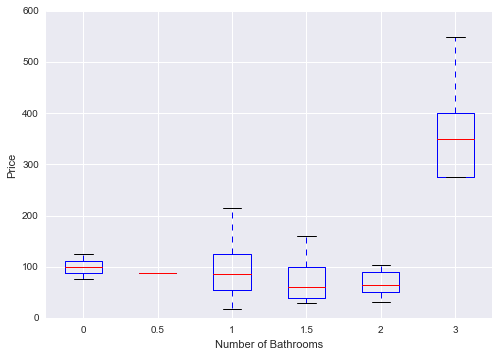

In [87]:
bathrooms = []
for name, group in airbnbDF.groupby(['bathrooms']):
    bathrooms.append(group['price'].as_matrix())
    
plt.boxplot(bathrooms)
plt.xticks([1,2,3,4,5,6], [0, 0.5, 1, 1.5, 2, 3])
plt.xlabel("Number of Bathrooms")
plt.ylabel("Price")

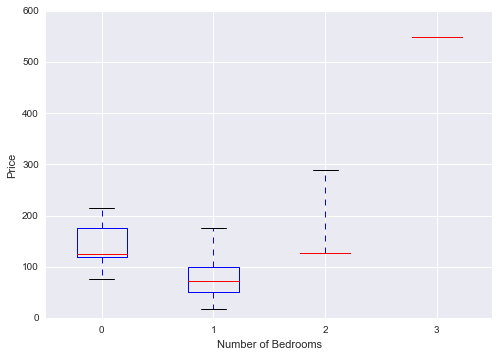

In [88]:
bedrooms = []
for name, group in airbnbDF.groupby(['bedrooms']):
    bedrooms.append(group['price'].as_matrix())

plt.boxplot(bedrooms)
plt.xticks([1,2,3,4], [0, 1, 2, 3])
plt.xlabel("Number of Bedrooms")
plt.ylabel("Price")

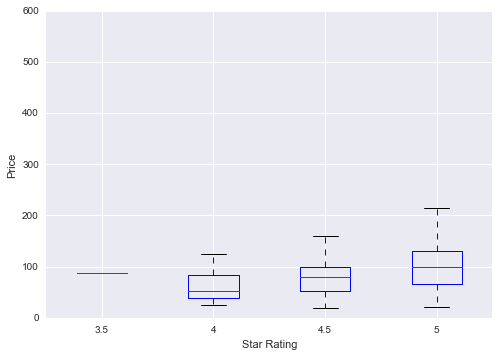

In [89]:
star_rating = []
for name, group in airbnbDF.groupby(['star_rating']):
    star_rating.append(group['price'].as_matrix())
    
plt.boxplot(star_rating)
plt.xticks([1,2,3,4], [3.5, 4, 4.5, 5])
plt.xlabel("Star Rating")
plt.ylabel("Price")

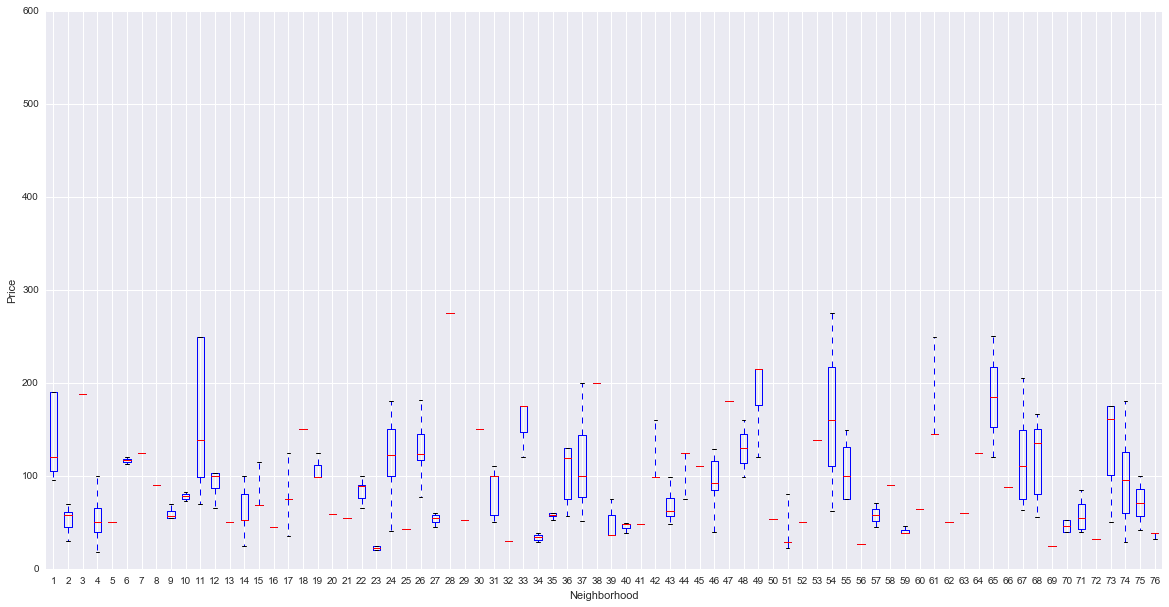

In [93]:
neighborhood = []
for name, group in airbnbDF.groupby(['neighborhood']):
    neighborhood.append(group['price'].as_matrix())
    
plt.figure(figsize=(20,10))
plt.boxplot(neighborhood)
plt.xlabel("Neighborhood")
plt.ylabel("Price")

Clearly, some neighborhoods are more expensive than others, so this would be a good variable to include in our model. Also, there appears to be some linear trend in the number of bedrooms and star rating, so we can include those variables as well.

### Multivariate Linear Regression

To do later...

### Hypothesis Testing

To do later...

## Part III: What Factors Influence Star Rating?

To be done later...